In [28]:
import sys
import glob
import re
import fnmatch
from os import listdir
from os.path import join, isfile, basename

import numpy as np
from numpy import float32, int32, uint8, dtype, genfromtxt

import pandas 

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
# VFB labels and label names
labels = [16,64,8,32,2,4,65,66,33,67,34,17,69,70,35,71,9,18,72,36,73,74,37,75,19,76,38,77,39,78,79,20,5,40,80,10,81,82,83,84,85,86,11,22,23,24,12,3,6,49,50,25,51,13,52,26,53,27,54,55,56,28,7,14,57,58,29,59,30,60,15,61,31,62,63]
label_names_file = '/groups/saalfeld/home/bogovicj/vfb/DrosAdultBRAINdomains/refData/Original_Index.tsv'

label_names = pandas.read_csv( label_names_file, delimiter='\t', header=0 )
# print label_names[ label_names['Stack id'] == 11 ]['JFRCtempate2010.mask130819' ].iloc[0]
# print label_names[ label_names['Stack id'] == 70 ]['JFRCtempate2010.mask130819' ].iloc[0]

def get_label_name( label_id ):
    return label_names[ label_names['Stack id'] == label_id ]['JFRCtempate2010.mask130819' ].iloc[0]

# label_names['JFRCtempate2010.mask130819']

label_shorthand_col ='JFRCtempate2010.mask130819'
label_id_col ='Stack id'


# Find left-right matching labels
rnames = label_names[ label_names.apply( lambda x : x[label_shorthand_col].endswith('_R'), axis=1 )]

lr_pair_list = []
for rn in rnames.loc[:,label_shorthand_col]:
    ln = rn.replace('_R','_L')
    id_R = label_names[ label_names[label_shorthand_col]==rn ].loc[:,label_id_col]
    id_L = label_names[ label_names[label_shorthand_col]==ln ].loc[:,label_id_col]
    lr_pair_list += [[id_R.values[0], id_L.values[0]]]
lr_pair_list = np.array( lr_pair_list )
# print lr_pair_list

In [3]:
ids = np.unique( label_names.as_matrix( columns=['Stack id']))
print ids

[ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 22 23 24 25 26 27
 28 29 30 31 32 33 34 35 36 37 38 39 40 49 50 51 52 53 54 55 56 57 58 59 60
 61 62 63 64 65 66 67 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86]


In [4]:
# Relevant directories

neuron_list_file="/nrs/saalfeld/john/projects/flyChemStainAtlas/eval/prefix_list_by_neuron.txt"
f=open(neuron_list_file)
tmp=f.read().splitlines()
f.close()
neurons = [ n.split(' ') for n in tmp ]

print ' '
name1 = 'ants_jfrc2'
jfrcDir = '/nrs/saalfeld/john/projects/flyChemStainAtlas/eval/ants_jfrc2/evalComp'
print jfrcDir

name2 = 'ants-el-ag_owl'
grpDir = '/nrs/saalfeld/john/projects/flyChemStainAtlas/eval_f/ants-el-ag_owl/evalComp'
print grpDir

names = [ name1, name2 ]
print names 

 
/nrs/saalfeld/john/projects/flyChemStainAtlas/eval/ants_jfrc2/evalComp
/nrs/saalfeld/john/projects/flyChemStainAtlas/eval_f/ants-el-ag_owl/evalComp
['ants_jfrc2', 'ants-el-ag_owl']


In [5]:
# jfrc_hist_sizes = pandas.read_csv( '/nrs/saalfeld/john/projects/flyChemStainAtlas/eval/ants_jfrc2/evalComp/totals.csv', header=None, names=['pair','count'] )
# grp_hist_sizes = pandas.read_csv( '/nrs/saalfeld/john/projects/flyChemStainAtlas/eval_f/ants-el-ag_owl/evalComp/totals.csv', header=None, names=['pair','count'] )


In [15]:
# Functions

def flatten( list_of_lists ):
    return [ item for sublist in list_of_lists for item in sublist ]

def getCount( df_counts, pair_name ):
    res = df_counts[ df_counts.pair == pair_name ]['count']

def normalizeHistogram( hist ):
    hist[:,1] = hist[:,1]/np.sum( hist[:,1])
    return hist

def plotHistBar( hist, title ):
    x = hist[1:-1,0]
    y = hist[1:-1,1]
    plt.bar( x, y )
    plt.xlabel('Distance')
    plt.ylabel('Freq')
    plt.title( title )
    
def plotHistsTogether( hists, names ):
    for i in range( len( hists )):
        hist = hists[ i ]
        x = hist[1:-1,0]
        y = hist[1:-1,1]
        plt.plot( x, y )

    plt.xlabel('Distance')
    plt.ylabel('Freq')
    plt.legend( names )
    
def findHistCsv( folder, label, line ):
    testf = join( folder, 'combined__labelHist_{}_line{}.csv'.format( label, line ))
    if isfile( testf ):
        return testf
    else:
        print'could not find file for label {} and line {} in folder {}'.format( label, line, folder )
        return None
    
def findHistStatCsv( line_names, folder, label, line ):
    out = []
    for prefix in line_names[ line ]:
        pattern = '{}/{}*_labelHist_stats_{}.csv'.format(folder,prefix,label)
#         print pattern
        possibles = glob.glob( pattern )
        #print 'possibles ', possibles
        out += possibles
    return out

def findCombinedDataCsv( folder, label, line ):
    out = []
    pattern = '{}/combined__labelData_{}_line{}.csv'.format(folder,label,line)
    possibles = glob.glob( pattern )
    out += possibles
    return out

def concatenateCentiles( centile_files, cent=0.5 ):
    out = np.array([[]])
    for f in centile_files:
        try:
            stats = genfromtxt( f, delimiter=',' )
            a = stats[1, np.argwhere(stats[0,:]==cent )]
            out = np.concatenate( (out,a), axis=1)
        except ValueError:
            continue
    return out

def getHistogramCounts( centile_files ):
    out = np.array([[]])

def cheap_hist_percentile( hist_in, percentile ):
    hist = hist_in[1:-1,:]
    total=np.sum(hist[:,1])
    cumsum=np.cumsum(hist[:,1])
    return hist[ cumsum > ( percentile * total ), 0 ][ 0 ]

def counts( df_pair_label_counts, names ):
    results = []
    for n in names: 
        pair=basename( n.replace('_stats_','_'))
#         print pair
        thiscount = df_pair_label_counts[ df_pair_label_counts[ 'pair' ] == pair ]['count']

        if thiscount.size != 1:
            continue

        results += [ thiscount.values ]
#         print results
        
    return np.mean( np.array( results ))


In [259]:
# Load the data 
line = 1
sample_counts = {}
grp_all_data = {}
jrc_all_data = {}

sz =  None 
for l in labels:
    jfrcDataFileList = findCombinedDataCsv( jfrcDir, l, line )
    grpDataFileList  = findCombinedDataCsv(  grpDir, l, line )
    
#     print grpDataFileList
#     print jfrcDataFileList
    grp_dat = genfromtxt( grpDataFileList[0], delimiter=',' )
    jrc_dat = genfromtxt( jfrcDataFileList[0], delimiter=',' )
    
    ng = len( grp_dat )
    nj = len( jrc_dat )
    
    grp_all_data[ l ] = grp_dat
    jrc_all_data[ l ] = jrc_dat
    sample_counts[ l ] =  ( nj + ng )


# sample_counts = np.array( sample_counts )
# sample_counts[ np.isnan( sample_counts ) ] = 0 

# # print sample_counts

# sort_idxs = ( np.argsort( sample_counts ) )[::-1] # Reverse so its in descending order
# # print sort_idxs

# sorted_counts = np.array( sample_counts )[ sort_idxs  ]
# labels_sorted_by_n_samples = np.array( labels )[ sort_idxs ]


# labels_of_interest = labels_sorted_by_n_samples[ sorted_counts > 0 ]
# sorted_counts_of_interest = sorted_counts[ sorted_counts > 0 ]
# # print labels_of_interest
# # print sorted_counts_of_interest

# xlabels = flatten( [ [ str(get_label_name(l)), ''] for l in labels_sorted_by_n_samples ] )

In [258]:
# Decide on label ordering and compile x-labels

sorted_idxs  = np.argsort( np.array( sample_counts.values() ))
# print 'sorted_idxs:'
# print sorted_idxs
# print ' '

sorted_labels = np.array( sample_counts.keys())[ sorted_idxs ]
sorted_labels = list(reversed(sorted_labels))
# print 'sorted_labels:'
# print sorted_labels
# print ' '

# print lr_pair_list[ np.where( lr_pair_list == 86 )[0], : ]

ordered_labels = []
xlabels = []

# Pick xlabels based on size, but make sure left and right are adjacent
for l in sorted_labels:
#     print l
    if l not in ordered_labels:
        if l in lr_pair_list:
            i,j =  np.where( lr_pair_list == l )
            jother = 0 if j==1 else 1
            alsoaddme = lr_pair_list[i,jother][0] 
            if alsoaddme < l:
                ordered_labels += [alsoaddme, l ]
            else:
                ordered_labels += [ l, alsoaddme ]
        else:
            ordered_labels += [l]
        
# print ' '
# print ordered_labels

xlabels = flatten( [ [ str(get_label_name(l)), ''] for l in ordered_labels ] )
# print xlabels

(51956,)
(132746,)
[1, 4, 10, 13, 19, 22, 28, 31, 37, 40, 46, 49, 55, 58, 64, 67, 73, 76, 82, 85, 91, 94, 100, 103, 109, 112, 118, 121, 127, 130, 136, 139, 145, 148, 154, 157, 163, 166, 172, 175, 181, 184, 190, 193, 199, 202, 208, 211, 217, 220, 226, 229, 235, 238, 244, 247, 253, 256, 262, 265, 271, 274, 280, 283, 289, 292, 298, 301, 307, 310, 316, 319, 325, 328, 334, 337, 343, 346, 352, 355, 361, 364, 370, 373, 379, 382, 388, 391, 397, 400, 406, 409, 415, 418, 424, 427, 433, 436, 442, 445, 451, 454, 460, 463, 469, 472, 478, 481, 487, 490, 496, 499, 505, 508, 514, 517, 523, 526, 532, 535, 541, 544, 550, 553, 559, 562, 568, 571, 577, 580, 586, 589, 595, 598, 604, 607, 613, 616, 622, 625, 631, 634, 640, 643, 649, 652, 658, 661, 667, 670]


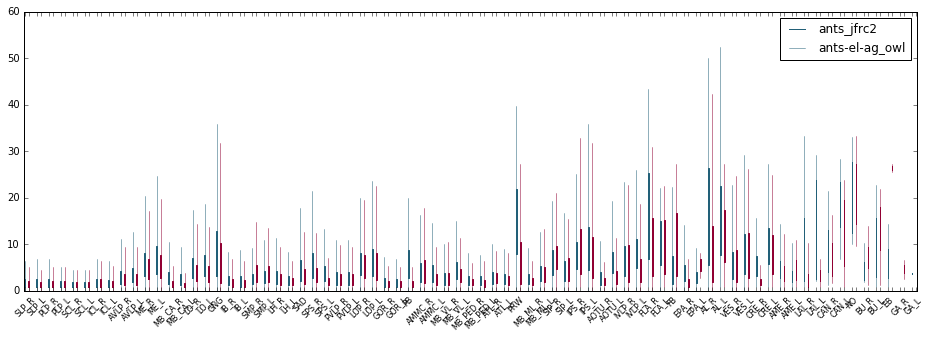

In [228]:
# make the sorted data set

print grp_all_data[27].shape
print jrc_all_data[27].shape

xpositions = []
small_space = 3
big_space = 6
p = 1

all_data = []
for l in ordered_labels:
    all_data += [ jrc_all_data[ l ] ]
    all_data += [ grp_all_data[ l ] ]

    xpositions += [ p, p + small_space ]
    p += ( big_space + small_space )

print xpositions
    
bp = plt.boxplot( all_data, positions=xpositions, whis=2.5, showfliers=False )

c1 = '#226078'
c2 = '#910033'
even = True
for box in bp['boxes']:
    if even:
        box.set( color=c1, linewidth=1)
    else:
        box.set( color=c2, linewidth=1)
    even = not even

i = 0
for w in bp['whiskers']:
    if i == 0 or i == 1:
        w.set( color=c1, linewidth=0.5, linestyle='-')
    else:
        w.set( color=c2, linewidth=0.5, linestyle='-')
    i += 1
    
    if i == 4: 
        i = 0
    
even = True
for m in bp['medians']:
    if even:
        m.set( color=c1, linewidth=1)
    else:
        m.set( color=c2, linewidth=1)
    even = not even

for c in bp['caps']:
    c.set_visible( False )
    
even = True
for flier in bp['fliers']:
#     flier.set_visible( False )
    if even:
        flier.set(marker='.', markeredgecolor=c1, markerfacecolor=c1, markersize=1, alpha=0.2 )
    else:
        flier.set(marker='.', markeredgecolor=c2, markerfacecolor=c2, markersize=1, alpha=0.2 )
    even = not even

plt.legend( names )

ax = plt.gca()
ax.set_xticklabels( xlabels )
a = plt.setp( ax.get_xticklabels(), rotation=45, fontsize=8 )

fig = plt.gcf()
a = fig.set_size_inches( 16, 5 )

plt.savefig('/nrs/saalfeld/john/projects/flyChemStainAtlas/comparisons/all_data_byLabel.svg')

In [255]:

def color_boxplot_by_group( bp, groups, colors ):
    for box,i in zip( bp['boxes'], np.arange(len( bp['boxes']))):
        box.set( color=colors[groups[i]])
    
    for med,i in zip( bp['medians'], np.arange(len( bp['medians']))):
#         med.set( color=colors[groups[i]])
        med.set( color='k')
        
    # repeat because there are two whiskers for each box
    for wskr,i in zip(  bp['whiskers'], np.repeat( np.array(groups), 2, axis = 0 ) ):
        wskr.set( color=colors[groups[i]])


6
[1, 4, 10, 13, 19, 22]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


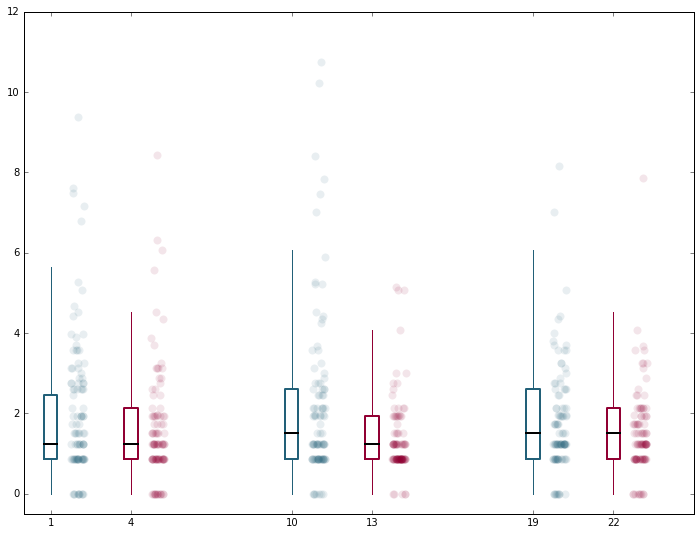

In [256]:

some_data = all_data[0:6]
some_xpositions = xpositions[0:6]
print len( some_data )
print some_xpositions 

groups = [0,1,0,1,0,1]
colors = ['#226078','#910033']
whisker_props = { 'linewidth' : 1.0, 'linestyle' : '-'}
box_props = { 'linewidth' : 2.0 }
med_props = { 'linewidth' : 2.0 }

max_scatter_pts = 100
scatter_radius = 0.5
print np.repeat( some_xpositions[0], 20 )

bp = plt.boxplot( some_data, positions=some_xpositions, whis=2, showcaps=False, showfliers=False,
                boxprops=box_props, whiskerprops=whisker_props, medianprops=med_props )

for i in range( len( some_data )):
    if( len(some_data[ i ]) <= max_scatter_pts ):
        sample = some_data[ i ]
    else:
        sample = some_data[ i ][ np.random.choice( len(some_data[i]), max_scatter_pts)]
    
    
    x = np.repeat( (1 + some_xpositions[i]), len( sample ))
    x = x + ( scatter_radius * np.random.rand( *x.shape ) - (scatter_radius / 2) )
    plt.plot( x, sample, linestyle='None', marker='o', markersize=8, markeredgewidth=0,
             markerfacecolor=colors[groups[i]], alpha=0.1 )
    
plt.gca().set_xlim([0,25])
plt.gca().set_ylim([-0.5,12])

color_boxplot_by_group( bp, groups, colors )

fig = plt.gcf()
_ = fig.set_size_inches( 12, 9 )

plt.savefig('/groups/saalfeld/home/bogovicj/box-scatter-plot-style2.svg')